# Bookshelf Dataset
The goal of this notebook is to learn how to wrangle data and learn about basic anomaly detection methods. 

In [2]:
pwd

'/Users/wang_to/Documents/University/Anomaly_detection/anomalies'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mat4py
import stumpy
import matplotlib.pylab as pl
#import ot 
import tensorflow as tf
import keras 
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split

import time

More strutureal health monitoring datasets available here (if interested):

https://www.lanl.gov/projects/national-security-education-center/engineering/software/shm-data-sets-and-software.php

# Organising Data

In [4]:
# Previous data structure from a prior data61 collaboration 
# Not the form you would find on the previous website

# Input file is .mat type from Matlab --- engineering collaborations
data = mat4py.loadmat('Building_Model.mat')
print(data.keys())

dict_keys(['SensorList', 'nSensors', 'EventIDs', 'X', 'nTests', 'nDamagedTests', 'nHealthyTests', 'EventSizes', 'labels_binary', 'F'])


To explain the data: SensorList gives the IDs of the 24 sensors. 270 tests were done with 150 tests on "non-damaged" bookshelf and 120 tests done on "damaged" bookshelf. Each sensor (24) recorded 270 events each, with each event containing 8192 data points. So X is a list of lists, with each X[i] containing 8192 floats. 

In [5]:
# Extracting columns
nTests = data['nTests']
nHealthy = data['nHealthyTests']
nDamage = data['nDamagedTests']
nSensors = data['nSensors']
X = data['X']

# Constructing columns for new data frame (which will be defined later)
info_cols = ['y_labels','damage_location','damage_level','voltage_level']
X_cols_time = ['Xt_'+str(i) for i in range(len(X[0]))]
cols = [X_cols_time + info_cols]

In [6]:
print('Total number of sensors: '+str(nSensors))
print('Total number of tests: '+str(nTests))
print()
print('Total number of healthy data: '+str(data['nHealthyTests']))
print('Total number of damage data: '+str(data['nDamagedTests']))
print()
print('Total number of data instances: '+str(len(X)) + ' (which is equal to 24 sensors x 270 events)') # There are 24 sensors x 270 events = 6480 data instances 
print('Length of each data recording: '+str(len(X[0]))) # Each data recording is 8192 longn sampled at 1600 hz = 1600 samples/sec

Total number of sensors: 24
Total number of tests: 270

Total number of healthy data: 150
Total number of damage data: 120

Total number of data instances: 6480 (which is equal to 24 sensors x 270 events)
Length of each data recording: 8192


### Organizing data to be in dictionary structure

But please feel free to organize the data however you like as convininent to you! : )

I just arranged this way for a dictoinary to be over sensor array, so that you can reference information like:

`data_dict['Sensor1']`


In [7]:
len(data["labels_binary"]) #healthy or not. labels are arranged linearly (1st sensor is the first 270 datapoints)
data["EventIDs"]


[['L00_D00_V02_071200_01_S1'],
 ['L00_D00_V02_071200_02_S1'],
 ['L00_D00_V02_071200_03_S1'],
 ['L00_D00_V02_071200_04_S1'],
 ['L00_D00_V02_071200_05_S1'],
 ['L00_D00_V02_071200_06_S1'],
 ['L00_D00_V02_071200_07_S1'],
 ['L00_D00_V02_071200_08_S1'],
 ['L00_D00_V02_071200_09_S1'],
 ['L00_D00_V02_071200_10_S1'],
 ['L00_D00_V02_071300_11_S1'],
 ['L00_D00_V02_071300_12_S1'],
 ['L00_D00_V02_071300_13_S1'],
 ['L00_D00_V02_071300_14_S1'],
 ['L00_D00_V02_071300_15_S1'],
 ['L00_D00_V02_071300_16_S1'],
 ['L00_D00_V02_071300_17_S1'],
 ['L00_D00_V02_071300_18_S1'],
 ['L00_D00_V02_071300_19_S1'],
 ['L00_D00_V02_071300_20_S1'],
 ['L00_D00_V02_071300_21_S1'],
 ['L00_D00_V02_071300_22_S1'],
 ['L00_D00_V02_071300_23_S1'],
 ['L00_D00_V02_071300_24_S1'],
 ['L00_D00_V02_071300_25_S1'],
 ['L00_D00_V02_071300_26_S1'],
 ['L00_D00_V02_071300_27_S1'],
 ['L00_D00_V02_071300_28_S1'],
 ['L00_D00_V02_071300_29_S1'],
 ['L00_D00_V02_071300_30_S1'],
 ['L00_D00_V02_071300_31_S1'],
 ['L00_D00_V02_071300_32_S1'],
 ['L00_D

In [8]:
time_start = time.time()

data_dict = {}
# Should I do some nise reduction in input signals???
for i in range(1,nSensors+1):
    
    # Extracting Data   
    X_time = X[nTests*(i-1):nTests*i]
    y = data['labels_binary'][nTests*(i-1):nTests*i] # collects LXX, DXX and VXX information
    locations = [ L[0][0:3] for L in data['EventIDs'][nTests*(i-1):nTests*i] ]
    damage_levels = [ L[0][4:7] for L in data['EventIDs'][nTests*(i-1):nTests*i] ] 
    shaker_voltage = [ L[0][8:11] for L in data['EventIDs'][nTests*(i-1):nTests*i] ]
    
    # Building Lists for Pandas
    sensor_data = []
    for j in range(len(X_time)):
        sensor_data.append(X_time[j]+y[j]+[locations[j]]+[damage_levels[j]]+[shaker_voltage[j]]) 
    
    # Constructing Time DataFrame
    sensor_time_df = pd.DataFrame(data=sensor_data, columns=cols) # 
    data_dict['Sensor'+str(i)] = sensor_time_df #
    
    print(f'Data processed for sensor {i}.')
    
time_end = time.time()

print(f'Time Taken: {time_end-time_start:.2f}s')

Data processed for sensor 1.
Data processed for sensor 2.
Data processed for sensor 3.
Data processed for sensor 4.
Data processed for sensor 5.
Data processed for sensor 6.
Data processed for sensor 7.
Data processed for sensor 8.
Data processed for sensor 9.
Data processed for sensor 10.
Data processed for sensor 11.
Data processed for sensor 12.
Data processed for sensor 13.
Data processed for sensor 14.
Data processed for sensor 15.
Data processed for sensor 16.
Data processed for sensor 17.
Data processed for sensor 18.
Data processed for sensor 19.
Data processed for sensor 20.
Data processed for sensor 21.
Data processed for sensor 22.
Data processed for sensor 23.
Data processed for sensor 24.
Time Taken: 34.81s


In [9]:
data_dict.keys()
len(data_dict['Sensor1']) # 270 "data recording events" ... 150 healthy .... 120 (various) damage cases


270

# Playing Around with the Data

In [10]:
# Some helper functions

# plot function
def multiplot(data, orientation = "vertical", col_names = False):
    '''data is a list of datasets to be plotted. '''
    n = len(data) 
    if orientation == "vertical":
        fig, axs = plt.subplots(1,n,sharey=True)
    elif orientation == "horizontal":
        fig, axs = plt.subplots(n,1, sharex=True)
    fig.suptitle("Comparing differing damage levels")
    fig.set_size_inches(15,10)
    for i in range(n):
        axs[i].plot(data[i].values, linewidth=0.2)
        if col_names != False: 
            axs[i].set_xlabel(col_names[i])

    return 

# Boolean for df.apply()
def boolean_rows(a):
    return(a[0] & a[1] & a[2])

def extract_inf(sens, one_hot = False):
    '''
    Input: sens is dataframe (as in usual input, like data_dict["Sensor1"].iloc[i] (ith test)'''
    y = sens["y_labels"]
    loc = sens["damage_location"]
    dam_level = sens["damage_level"]
    volt = sens["voltage_level"]
    if one_hot == True:
        data = sens[:-10]
        D00 = sens["D00"]
        DB0 = sens["DB0"]
        DBB = sens["DBB"]
        DHT = sens["DHT"]
        D05 = sens["D05"]
        D10 = sens["D10"]
        return data, y, loc, dam_level, volt, [D00, DB0, DBB, DHT, D05, D10]
    else:
        data = sens[:-4]
        return data, y, loc, dam_level, volt
    


(Xt_0       0.015912
 Xt_1       0.034565
 Xt_2        0.00965
 Xt_3       0.018976
 Xt_4       0.007931
              ...   
 Xt_8187    0.021511
 Xt_8188     0.04966
 Xt_8189   -0.003863
 Xt_8190    0.035092
 Xt_8191    0.039466
 Name: 0, Length: 8192, dtype: object,
 0,
 'L00',
 'D00',
 'V02')

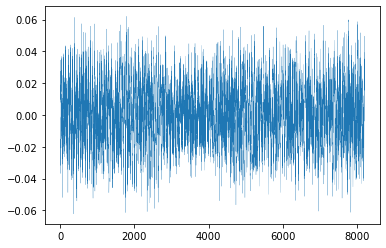

In [11]:
# .iloc[0] --> The "zeroth" recording
# [:-4] --> Not include last four values o: y_labels ... damage_location ... damage_level .... voltage_level
first = data_dict["Sensor1"].iloc[0][:-4].values
plt.plot(first, linewidth=0.2) 

extract_inf(data_dict["Sensor1"].iloc[0])


## Notes to myself
- LXX is the damage location. L00 is undamaged. We have L1C (at floor 1 location C), L3A (floor 3 location A) and L1C (both areas damaged).
- DXX is damage level. DB0: bolts were removed between bracket and plate. DBB: brackets were completely removed. DHT: left in at hand torque. DO5/D10 indicates torque level (5 or 10 ft Lbs)
- VXX: input level of the shaker (2,5,8 volts).
- Next 6 digits are the date (data collected in 2000) and the final digits are the set number.


# Comparison of Different Voltage levels

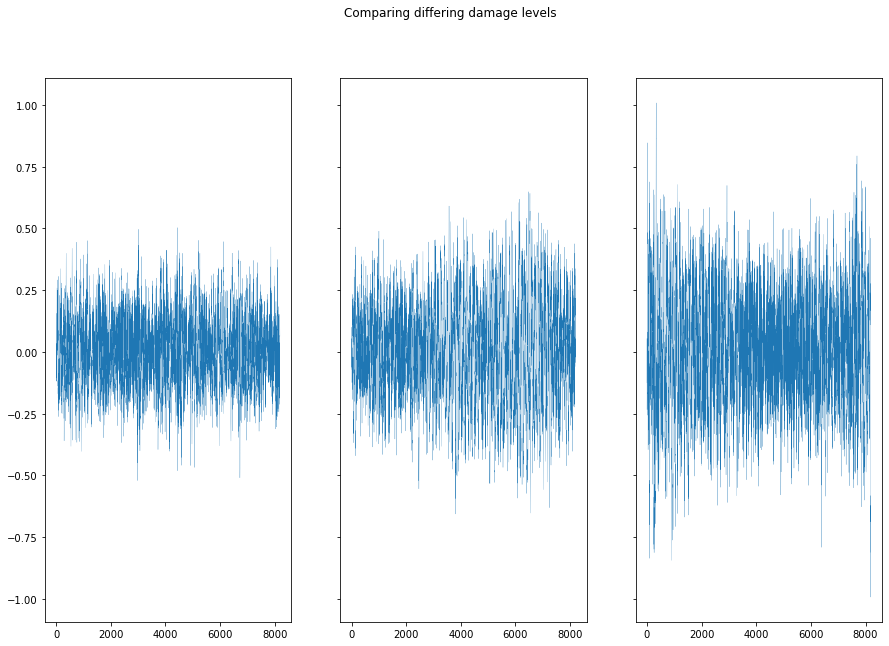

In [12]:
#find datapoints involving different kinds of voltages from sensor1
#DBB, voltage V02, V05, V08
sens1 = data_dict["Sensor1"]
ind = (sens1["damage_level"]=="DBB")
DBB_damaged = sens1[ind.squeeze(axis=1)]

DBB_V02 = DBB_damaged[(DBB_damaged["voltage_level"]=="V02").squeeze(axis=1)]
DBB_V05 = DBB_damaged[(DBB_damaged["voltage_level"]=="V05").squeeze(axis=1)]
DBB_V08 = DBB_damaged[(DBB_damaged["voltage_level"]=="V08").squeeze(axis=1)]

DBB_V02_0 = DBB_V02.iloc[0]
DBB_V05_0 = DBB_V05.iloc[0]
DBB_V08_0 = DBB_V08.iloc[0]

data_V02, _, _, _, _ = extract_inf(DBB_V02_0)
data_V05, _, _, _, _ = extract_inf(DBB_V05_0)
data_V08, _, _, _, _ = extract_inf(DBB_V08_0)

data_volt = [data_V02, data_V05, data_V08]
multiplot(data_volt)
plt.savefig("voltage_comparisons.png")


# V02, V05 seem almost exactly the same; V08 peaks higher?
# Hypothesis: higher voltage leads to higher variance and larger peaks in the data.
# It's possible that floor 3 experiences larger accelerations due to higher floor, so we could take a peek at that data as well
# Also, bigger differences in having 13 damaged?


# Comparison of Different Damage Levels 

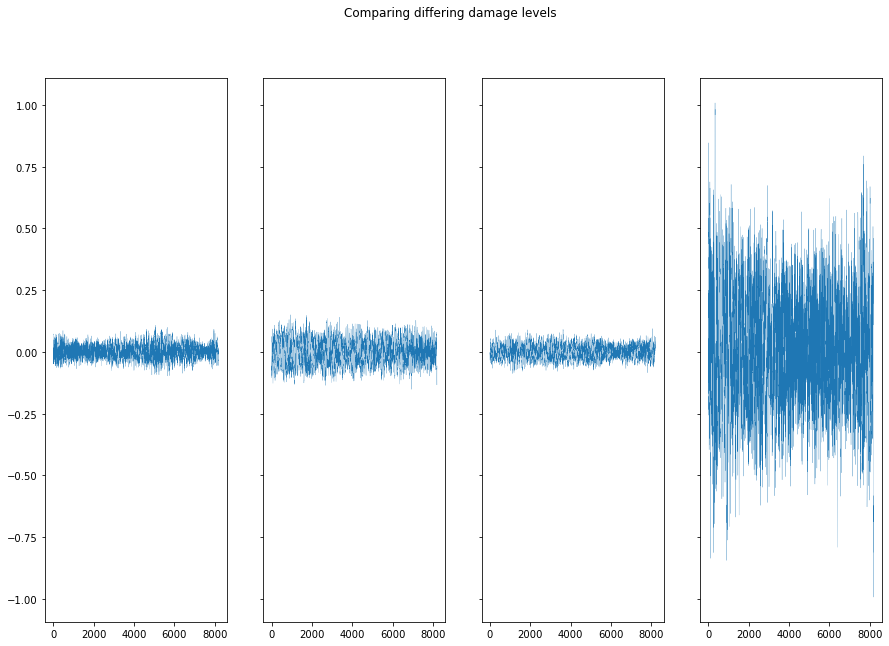

In [13]:
cases = [['L00','D00','V08'],   ['L1C','DB0','V08'],     ['L1C','DBB','V08'],      ['L13','DBB','V08']]
col_names = [["damage_location"], ["damage_level"], ["voltage_level"]]

sens1 = data_dict["Sensor1"] #probably better to loop this 
ind_D00 = (sens1[col_names]==cases[0])
ind_DB0 = (sens1[col_names]==cases[1])
ind_DBB = (sens1[col_names]==cases[2])
ind_DBB_2 =  (sens1[col_names]==cases[3])

# turn the indicators into a single T/F and find corresponding rows
L00_D00_8 = sens1[ind_D00.apply(boolean_rows, axis=1)]
L00_DB0_8 = sens1[ind_DB0.apply(boolean_rows, axis=1)]
L00_DBB_1_8 = sens1[ind_DBB.apply(boolean_rows, axis=1)]
L00_DBB_13_8 = sens1[ind_DBB_2.apply(boolean_rows, axis=1)]

# just extract out the data part from the first instance of each type of damage for visualisation purposes
data_L00_D00_8, _, _, _, _ = extract_inf(L00_D00_8.iloc[0])
data_L00_DB0_8, _, _, _, _ = extract_inf(L00_DB0_8.iloc[0])
data_L00_DBB_1_8, _, _, _, _ = extract_inf(L00_DBB_1_8.iloc[0])
data_L00_DBB_13_8, _, _, _, _ = extract_inf(L00_DBB_13_8.iloc[0])

cases_damage_data = [data_L00_D00_8, data_L00_DB0_8, data_L00_DBB_1_8,data_L00_DBB_13_8]
multiplot(cases_damage_data)
plt.savefig("Damage_comparisons.png")


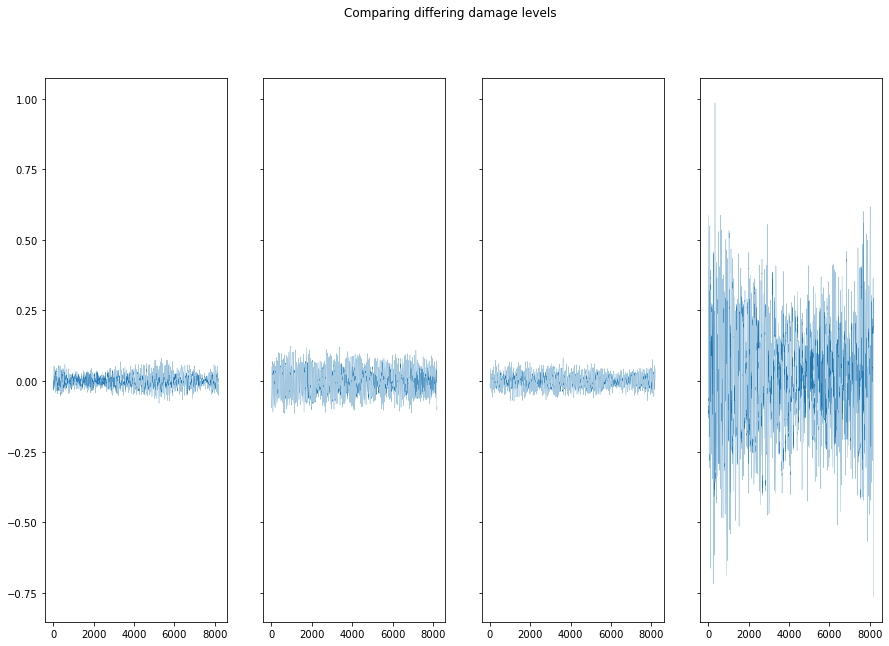

In [14]:
MA_damage_data = [data.rolling(window=5).mean() for data in cases_damage_data]    
multiplot(MA_damage_data)
plt.savefig("MA_damages.png")


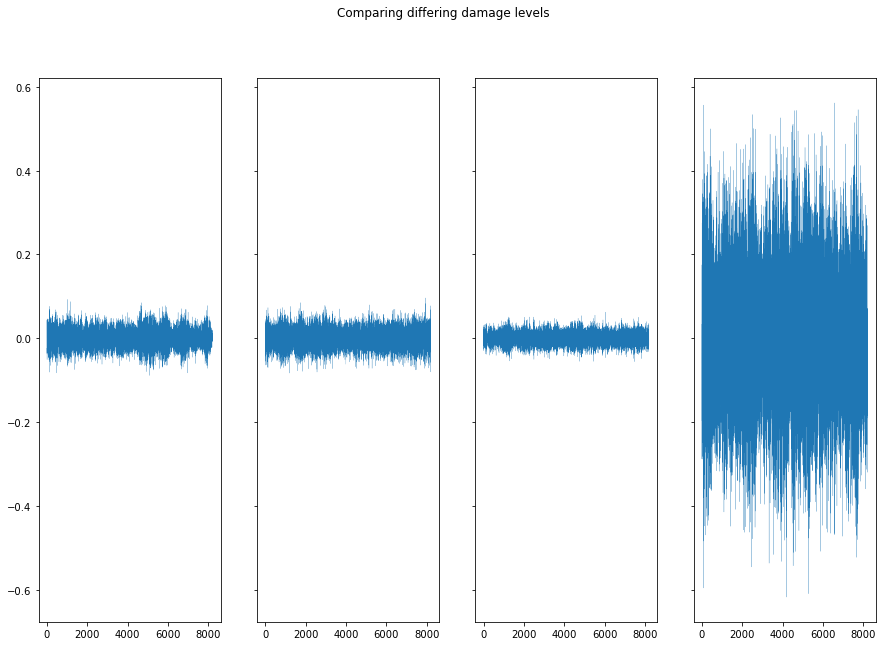

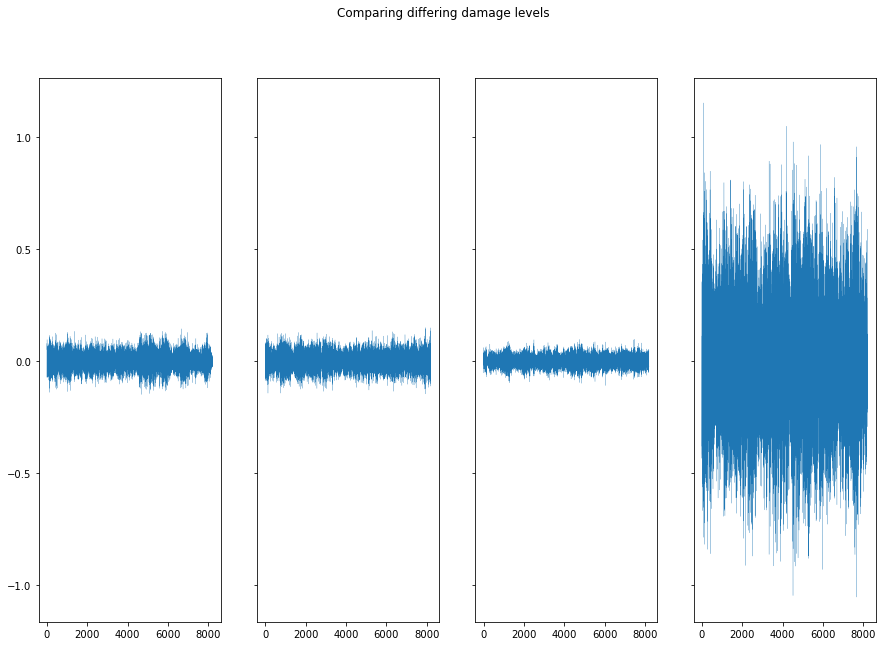

In [15]:
# By the way, I just want to see what happens after differencing 
diff_damage_data = [data.diff() for data in cases_damage_data]
multiplot(diff_damage_data)
# looks even noisier than before; some cancellation happens after one differencing

diff2_damage_data = [data.diff() for data in diff_damage_data]
multiplot(diff2_damage_data)


# Thoughts 
- Characterise damage by amount of variation from the mean? (obtain features from each series then feed into a neural network/log regressor?). We can do this if we split up the information from each sensor into 8192 blocks - may not be the idea of our work? (we want to detect a transition/change in behaviour, rather than just categorising 8192-long signal)
- Can we spot similar patterns when we concatenate these data points into one? (use matrix profile of size 8192?). If we did not know that each experiment was ~5 seconds long, how would we determine the approximate size of anomalous signals?


# Detect Transition with Matrix Profiles
In this section, the aim is to concatenate together homogeneous sensor information and use matrix profile to detect a "change" in behaviour of the time series. Highly experimental!

Motif length: 512. Motif located at 558. Nearest neighbour: 8750
Potential discord/anomaly located at 24092 with distance 24.81005207865679.
Motif length: 1024. Motif located at 8358. Nearest neighbour: 166
Potential discord/anomaly located at 23586 with distance 35.88648981976081.
Motif length: 2048. Motif located at 489. Nearest neighbour: 8681
Potential discord/anomaly located at 22618 with distance 53.48052385216103.
Motif length: 4096. Motif located at 124. Nearest neighbour: 8316
Potential discord/anomaly located at 20777 with distance 78.27907557626624.
Motif length: 8192. Motif located at 0. Nearest neighbour: 8192
Potential discord/anomaly located at 16778 with distance 111.21258777218192.


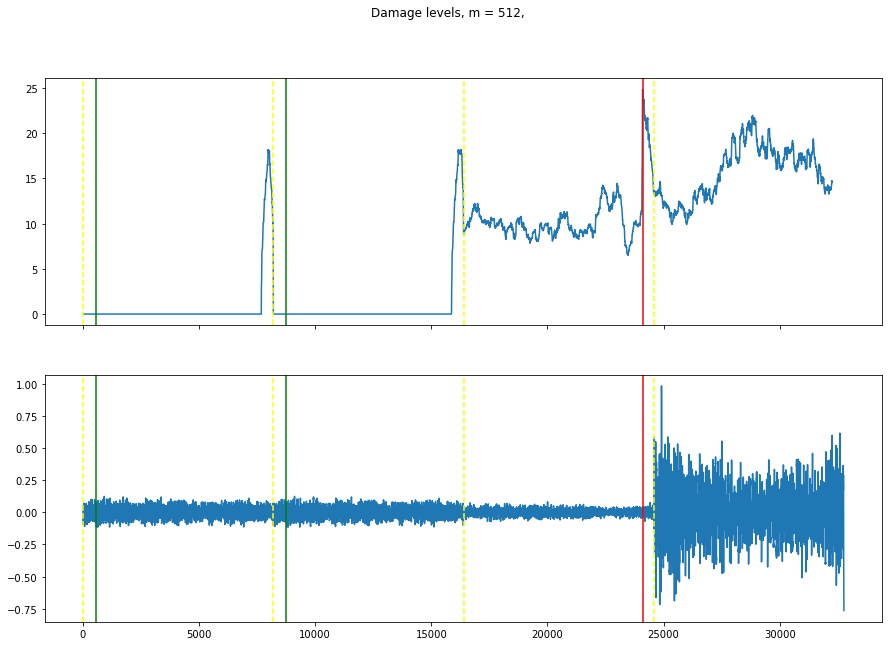

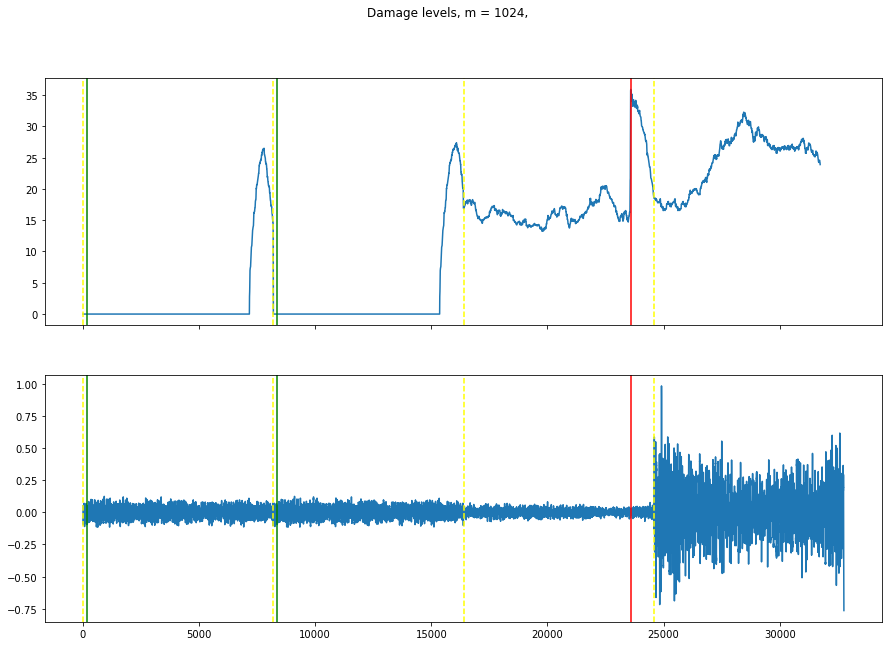

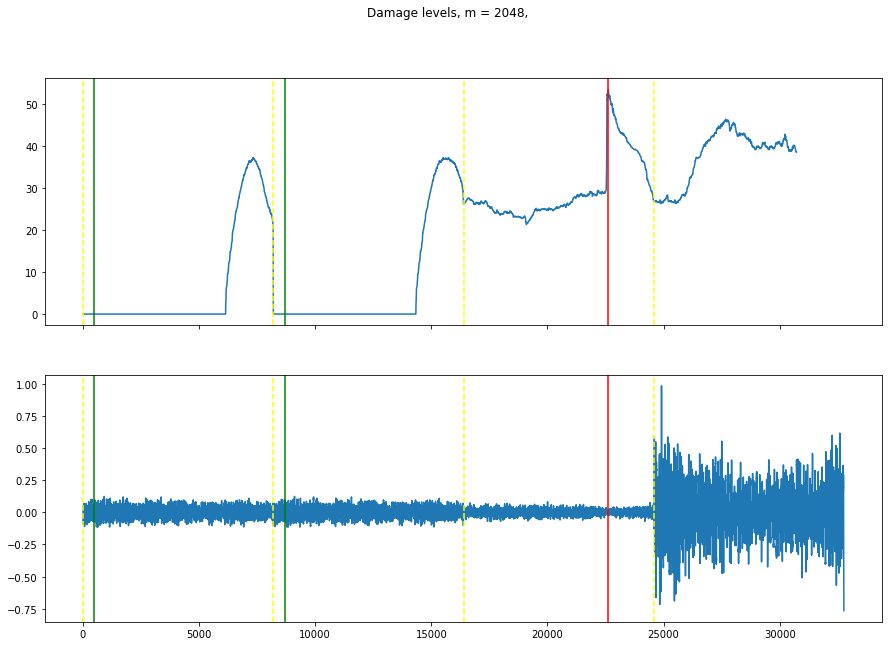

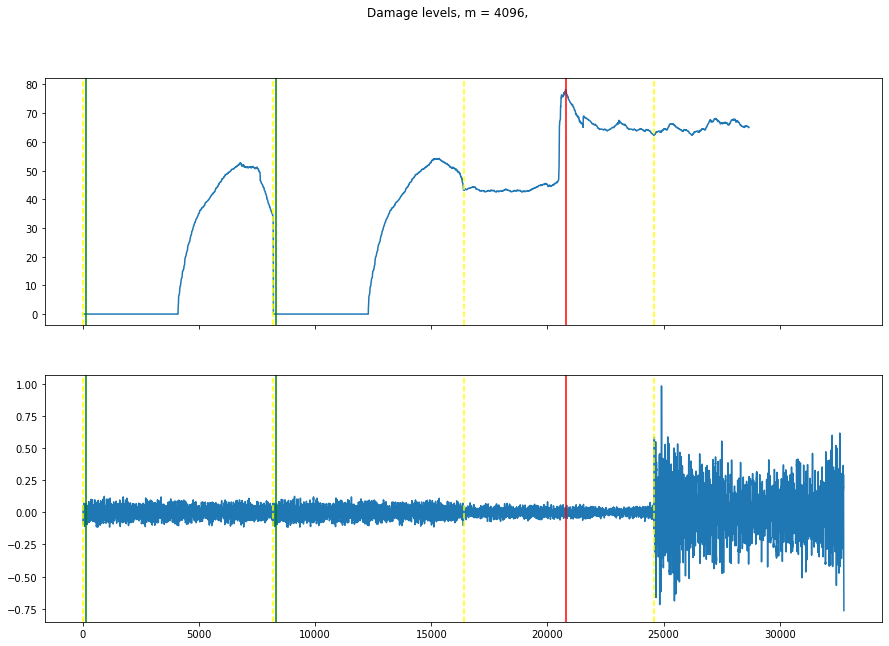

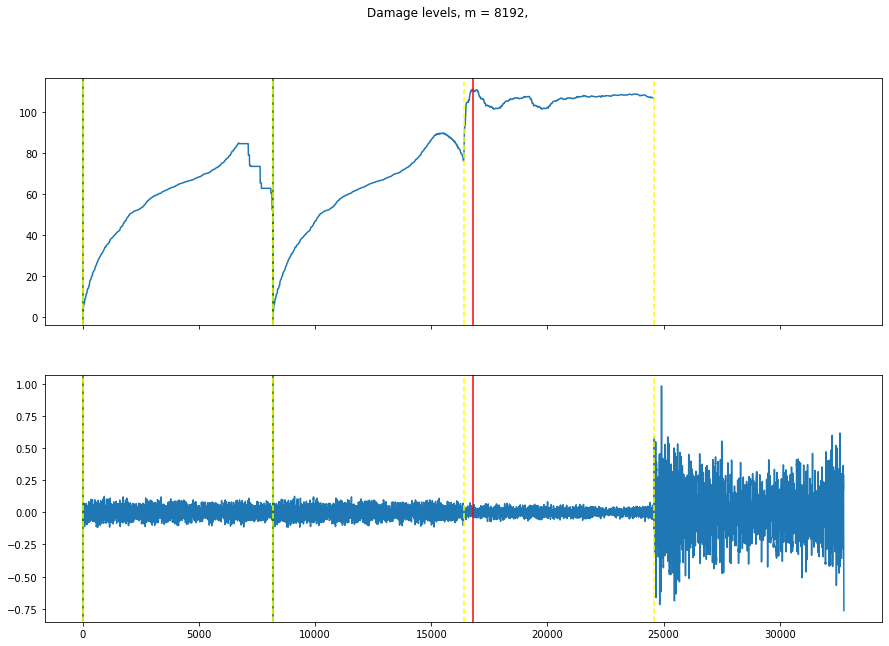

In [16]:
ts_cat= pd.concat([data_L00_DB0_8, data_L00_DB0_8, data_L00_DBB_1_8, data_L00_DBB_13_8],axis=0)
# there are 4 distinct transitions, each 8192 data points long. Can we detect the transition betweeen each damage type?

#smoothen
ts_cat = ts_cat.rolling(window=5).mean().dropna()

for m in [512, 1024, 2048, 4096, 8192]:
    mp = stumpy.stump(ts_cat.astype(float), m)
    #multiplot([pd.DataFrame(mp[:,0]), pd.DataFrame(ts_cat)], orientation="horizontal") just do this code manually

    mp_idx = np.argsort(mp[0:, 0])[0] #take the 0th columns first element
    nearest_neighbour_idx = mp[mp_idx, 1]
    print(f"Motif length: {m}. Motif located at {mp_idx}. Nearest neighbour: {nearest_neighbour_idx}")

    # discord 
    discord_idx = np.argsort(mp[:, 0])[-1]
    discord_dist = mp[discord_idx, 0]
    print(f"Potential discord/anomaly located at {discord_idx} with distance {discord_dist}.")

    fig, axs = plt.subplots(2,1, sharex=True)
    fig.suptitle(f"Damage levels, m = {m}, ")
    
    for id_x, data in enumerate([mp[:,0], ts_cat.values]):

        axs[id_x].plot(data)
        axs[id_x].set_xlabel("")
        axs[id_x].axvline(x=mp_idx, color="g")
        axs[id_x].axvline(x=nearest_neighbour_idx, color="g")
        axs[id_x].axvline(x=discord_idx, color="r")

    #actual split points
    split = np.arange(0,4*8192,8192)
    for x in split:
        axs[0].axvline(x=x, color="yellow", linestyle="dashed")
        axs[1].axvline(x=x, color="yellow", linestyle="dashed")
    

    fig.set_size_inches(15,10)


#yellow is actual split points, green is detected nearest neighbour, red is detected discord area

# X - mu / sigma , if X ~ N(mu, sigma^2), then X - mu / sigma ~ N(0,1)



In [17]:
np.shape(mp) # stumpy.stump returns: 
# 0. matrix profile values (z-normalised Euclidean distances) 
# 1. matrix profile indices
# 2.
# 3. 


(24573, 4)

In [18]:
np.fft.fft(ts_cat)

array([ 94.2536075 +8.27116153e-15j,  34.81960589+4.36200308e+01j,
        -5.3787995 +3.85121317e+01j, ..., -16.44677396-9.07903211e+00j,
        -5.3787995 -3.85121317e+01j,  34.81960589-4.36200308e+01j])

/Users/wang_to/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


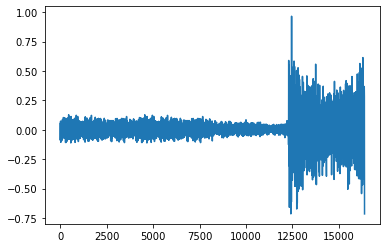

In [19]:
ts_cat_fft = np.fft.fft(ts_cat)
mod_fft = (np.abs(ts_cat_fft))**2
n = len(mod_fft)

#plt.plot(mod_fft[0:int(n/2)-10000]) # well, I wasn't expecting any trends with my fake data anyway
# smoothing?
# smoothies?

plt.plot(np.fft.ifft(ts_cat_fft[0:int(n/2)]))

#mod_fft[0:int(n/2)]


In [20]:
np.floor(n/2)

16382.0

# Categorise Data based on Simple Features
In this section, the aim is to categorise damage levels (possibly try voltage) when given a particular 8192-point sequence experiment.
- Idea: clear deviations in each time series can be detected in amplitude and total variance from the mean by eye. If we can compute several features for each time series, we can regress on these features to predict the damage level. This can clearly be done for Sensor 1, DBB13 versus the other damage levels, but it is much harder to do so between the other three damage levels.

In [22]:
# obtain samples of healthy and damaged cases for sensor 1
sens1 = data_dict["Sensor1"].copy() # this was previously defined for the voltage levels
voltage_levels = ["V02", "V05", "V08"]

for volt_levs in voltage_levels:
    sens1[volt_levs] = sens1["voltage_level"].transform(lambda a: a == volt_levs, axis = 0)
    sens1[volt_levs] = sens1[volt_levs].astype(int)

healthy_s1 = sens1[(sens1["y_labels"]==0).squeeze(axis=1)]
damaged_s1 = sens1[(sens1["y_labels"]==1).squeeze(axis=1)]

data_healthy_s1 = healthy_s1.iloc[:,0:-10]
data_damaged_s1 = damaged_s1.iloc[:,0:-10]


In [23]:
# Generate some useful features 

data_healthy_s1["mean"] = data_healthy_s1.apply(np.mean, axis=1)
data_healthy_s1["max"] = data_healthy_s1.apply(max, axis = 1)
data_healthy_s1["min"] = data_healthy_s1.apply(min, axis = 1)
data_healthy_s1["sum"] = data_healthy_s1.apply(np.linalg.norm, axis = 1)

data_damaged_s1["mean"] = data_damaged_s1.apply(np.mean, axis=1)
data_damaged_s1["max"] = data_damaged_s1.apply(max, axis = 1)
data_damaged_s1["min"] = data_damaged_s1.apply(min, axis = 1)
data_damaged_s1["sum"] = data_damaged_s1.apply(np.linalg.norm, axis = 1)


In [24]:
# Collect features together into one dataframe
# healthy features
min_max = ["mean", "max", "min", "sum"]
volts_y_labels = ["V02", "V05", "V08", "y_labels"]

health_features = data_healthy_s1[min_max]
volt_health_features = healthy_s1[volts_y_labels]
healthy_input = pd.concat([health_features, volt_health_features], axis=1)


# damaged features
damage_features = data_damaged_s1[min_max]
volt_damage_features = damaged_s1[volts_y_labels]
# combine 
damaged_input = pd.concat([damage_features, volt_damage_features], axis=1)


In [25]:
#check the inputs look okay. Time to feed this into a regressor/network!
damaged_input
healthy_input


,mean,max,min,sum,V02,V05,V08,y_labels
0,0.000661,0.062118,-0.062169,1.774758,1,0,0,0
1,0.000709,0.083459,-0.088275,2.085767,1,0,0,0
2,0.000706,0.093108,-0.091134,2.484239,1,0,0,0
3,0.000692,0.096359,-0.087645,2.271500,1,0,0,0
4,0.000663,0.088803,-0.111110,2.422891,1,0,0,0
...,...,...,...,...,...,...,...,...
145,0.008544,1.060200,-1.088200,24.625592,0,0,1,0
146,0.008933,0.865310,-0.753640,20.310849,0,0,1,0
147,0.009325,0.896260,-0.846790,24.433244,0,0,1,0
148,0.008589,0.919920,-0.932490,22.810203,0,0,1,0


In [26]:
complete_input = pd.concat([healthy_input, damaged_input], axis=0)
complete_input # put data together, if needed

,mean,max,min,sum,V02,V05,V08,y_labels
0,0.000661,0.062118,-0.062169,1.774758,1,0,0,0
1,0.000709,0.083459,-0.088275,2.085767,1,0,0,0
2,0.000706,0.093108,-0.091134,2.484239,1,0,0,0
3,0.000692,0.096359,-0.087645,2.271500,1,0,0,0
4,0.000663,0.088803,-0.111110,2.422891,1,0,0,0
...,...,...,...,...,...,...,...,...
265,0.008697,1.070900,-1.076700,26.467169,0,0,1,1
266,0.008777,0.817860,-0.744180,20.932004,0,0,1,1
267,0.009400,1.012800,-1.015100,23.731456,0,0,1,1
268,0.009480,1.077500,-1.046700,26.838052,0,0,1,1


In [28]:
features = ["mean", "max", "min", "sum", "V02", "V05", "V08"]
target = "y_labels"
train_X, test_X, train_Y, test_Y = train_test_split(complete_input[features], complete_input[target])

In [40]:
# Just throw a network on it and see what happens
class linear_nn(tf.keras.Model):
    def __init__(self, n):
        super(linear_nn, self).__init__()
        self.dense1 = Dense(n, input_dim = 7, activation="relu")
        self.dense2 = Dense(n, input_dim = n, activation="relu")
        self.out = Dense(1, activation = "sigmoid")
        self.dropout = Dropout(rate=0.5)
    
    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        if training:
            x = self.dropout(x, training=training)
        return self.out(x)

In [41]:
model = linear_nn(100)
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_X.values, train_Y.values, validation_data = (test_X.values, test_Y.values), epochs = 1000,verbose=0)

In [39]:
vals_train, train_acc = model.evaluate(train_X.values, train_Y.values,verbose=0)
vals_test, test_acc = model.evaluate(test_X.values, test_Y.values,verbose=0)
print(f"Validation accuracies: train - {train_acc:.3f}, test - {test_acc:.3f}")


Validation accuracies: train - 0.698, test - 0.588


In [ ]:
# Data info
samples = 8192   # Counts
sample_freq = 1600 # Hz
total_time = 8192 / 1600 # 5.12 seconds

# Proposed Task(s)

Consider the following cases, from no damage to steadily building up damage across structure. Do you feel it is possible to:

 1. Can you distinguish between **different** damage cases?
 2. Is it possible to localize or **"characterize"** this damage?
 3. Is there any difference between voltages? (I personally couldn't find much).
 
Ultimately please choose your own task, as you see fit. The idea is to get "first hand experience" with some kind of real data, and then to describe your thought process, coding choices, or mathematical choices. : )

In [ ]:
# FOR EXAMPLE: You can consider the following cases:

#       No Damage                # Mild damage @ L1C     # Large damage @ L1C      # Large damage @ L1C AND L3A
cases = [['L00','D00','V08'],   ['L1C','DB0','V08'],     ['L1C','DBB','V08'],      ['L13','DBB','V08']]

## Current(ish) Approach:

 1. *Matrix Profile:* Try to clean signal. Try to convert signal to Fourier domain (for example), or Wavelet domain or anything else in mind (feature engineering task)
 
 https://stumpy.readthedocs.io/en/latest/index.html
 
 
 2. *Semantic Segmentation:* Use matrix profile to find transitions in underlying signal
 
 https://stumpy.readthedocs.io/en/latest/Tutorial_Semantic_Segmentation.html
 
 3. *Information Combination:* Try to "combine" information from multiple sensors (there are 24 in total), by a barycentre approach (in particular Wasserstein barycentre)

 https://pythonot.github.io/auto_examples/unbalanced-partial/plot_UOT_barycenter_1D.html


 #### Note(s):
 
 
 When cleaning signal, consider something simple like moving average to remove noise.
 
 *If* you chose to use matrix profile, remember it likes "repetitive looking features". It characterises new events by seeing how different these "repetitive looking features" start to change.
 
 Notice that the current approach is not very probabilistic...
 
 Feature engineering of time series signals *can* be difficult. I don't believe it is possible to (convincingly) solve current problem with transforming or modifying the signals some way

In [ ]:
ss = pd.read_csv("sunspot.csv",header=None)
fft_ss = np.fft.fft(ss)
year = ss.iloc[:,0]
dominants = abs(fft_ss)**2


In [ ]:
data = ss.iloc[:,1]
data
plt.plot(abs(np.fft.fft(data))**2)

In [ ]:
year